In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict
from itertools import combinations,combinations_with_replacement

import src.utils.helper_functions as helper

In [2]:
os.environ['PATH'] = f"/home/brett/work/OrthogonalTrainValSplits/hashFrag/src/hashFrag:{os.environ['PATH']}"

In [3]:
current_dir = os.getcwd()
fasta_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.fa.gz")
score_matrix_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.score_matrix.csv.gz")
collisions_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.collisions.pbz2")
recall_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.recall_analysis.csv.gz")
filtered_collisions_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.filtered_collisions.pbz2")

# 0 - Computing all pairwise comparisons

In [12]:
# %%time

# fasta_dict = helper.parse_fasta_to_dictionary(fasta_path)

# n   = len(fasta_dict)
# ids = list(fasta_dict)
# arr = np.zeros(shape=(n,n),dtype=np.float32)
# for i,j in tqdm(combinations_with_replacement(range(n),2)):
#     id_i = ids[i]
#     id_j = ids[j]
#     seq_i = fasta_dict[id_i]
#     seq_j = fasta_dict[id_j]
#     score = helper.compute_sw_score(seq_i,seq_j)
#     arr[i,j] = score
#     arr[j,i] = score

# df = pd.DataFrame(arr,index=ids,columns=ids)
# df.to_csv(score_matrix_path,compression="gzip")
# display(df.head(5))
# print(df.shape)

# 1 - Identifying candidate similar sequences

## 1A - `lsh_forest`

In [5]:
%%bash

export PATH=./src/hashFrag:$PATH 

FASTA_PATH=$PWD/example_data/K562_clean.sample1000.fa.gz
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.collisions.pbz2

./src/hashFrag lsh_forest -f $FASTA_PATH -k 11 -p 256 -t 256 -n 1000 -s 1 -o $OUTPUT_PATH

LSH Forest process finished and written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.collisions.pbz2


## 1B - `blastn`

In [6]:
%%bash

FASTA_PATH=$PWD/example_data/K562_clean.sample1000.fa.gz
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.blastn_collisions.pbz2

# ./src/hashFrag blastn -f $FASTA_PATH -w 11 -B '-max_target_seqs 1000' -o $OUTPUT_PATH
./src/hashFrag blastn -f $FASTA_PATH -w 11 -o $OUTPUT_PATH



Building a new DB, current time: 11/20/2024 03:28:12
New DB name:   /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.blastdb
New DB title:  K562_clean.sample1000
Sequence type: Nucleotide
Deleted existing Nucleotide BLAST database named /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.blastdb
Keep MBits: T
Maximum file size: 1000000000B
Adding sequences from FASTA; added 1000 sequences in 0.278893 seconds.




BLASTn process finished and written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.blastn_collisions.pbz2


# 2 - `compute_recall`: LSH Forest

In [7]:
%%bash

COLLISIONS_PATH=$PWD/example_data/K562_clean.sample1000.collisions.pbz2
SCORE_MATRIX_PATH=$PWD/example_data/K562_clean.sample1000.score_matrix.csv.gz
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.recall_analysis.csv.gz

./src/hashFrag compute_recall -c $COLLISIONS_PATH -d $SCORE_MATRIX_PATH -s 1 -o $OUTPUT_PATH

Recall calculation results written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.recall_analysis.csv.gz


In [7]:
recall_df = pd.read_csv(recall_path)
display(recall_df.head(2))
print(recall_df.shape)

,threshold,TP,FP,TN,FN,recall,FPR
0,13.0,10896,0,0,989104,0.010896,0.0
1,14.0,10896,0,6,989098,0.010896,0.0


(188, 7)


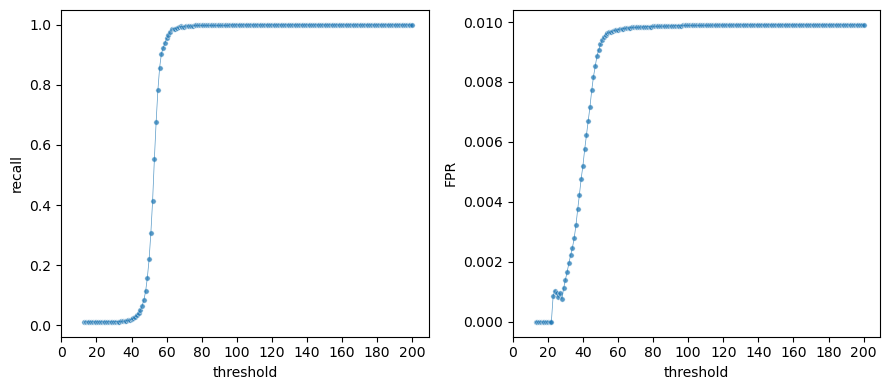

In [22]:
fig,axes = plt.subplots(1,2,figsize=(9,4))
sns.lineplot(recall_df,x="threshold",y="recall",ax=axes[0],alpha=0.75,linewidth=0.5)
sns.scatterplot(recall_df,x="threshold",y="recall",ax=axes[0],alpha=0.75,linewidth=0.5,s=15)
axes[0].set_xticks(np.arange(0,220,20))

sns.lineplot(recall_df,x="threshold",y="FPR",ax=axes[1],alpha=0.75,linewidth=0.5)
sns.scatterplot(recall_df,x="threshold",y="FPR",ax=axes[1],alpha=0.75,linewidth=0.5,s=15)
axes[1].set_xticks(np.arange(0,220,20))
plt.tight_layout()
plt.show()

## 2.1 - `compute_recall`: BLASTn

In [8]:
%%bash

COLLISIONS_PATH=$PWD/example_data/K562_clean.sample1000.blastn_collisions.pbz2
SCORE_MATRIX_PATH=$PWD/example_data/K562_clean.sample1000.score_matrix.csv.gz
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.blastn_recall_analysis.csv.gz

./src/hashFrag compute_recall -c $COLLISIONS_PATH -d $SCORE_MATRIX_PATH -s 1 -o $OUTPUT_PATH

Recall calculation results written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.blastn_recall_analysis.csv.gz


In [9]:
blast_recall_path = os.path.join(current_dir,"example_data","K562_clean.sample1000.blastn_recall_analysis.csv.gz")
blast_recall_df = pd.read_csv(blast_recall_path)
display(blast_recall_df.head(2))
print(blast_recall_df.shape)

,threshold,TP,FP,TN,FN,recall,FPR
0,13.0,12504,0,0,987496,0.012504,0.0
1,14.0,12504,0,6,987490,0.012504,0.0


(188, 7)


In [10]:
recall_df["method"]       = "lsh_forest"
blast_recall_df["method"] = "blastn"
combined_recall_df = pd.concat([recall_df,blast_recall_df])
combined_recall_df.head(2)


,threshold,TP,FP,TN,FN,recall,FPR,method
0,13.0,10896,0,0,989104,0.010896,0.0,lsh_forest
1,14.0,10896,0,6,989098,0.010896,0.0,lsh_forest


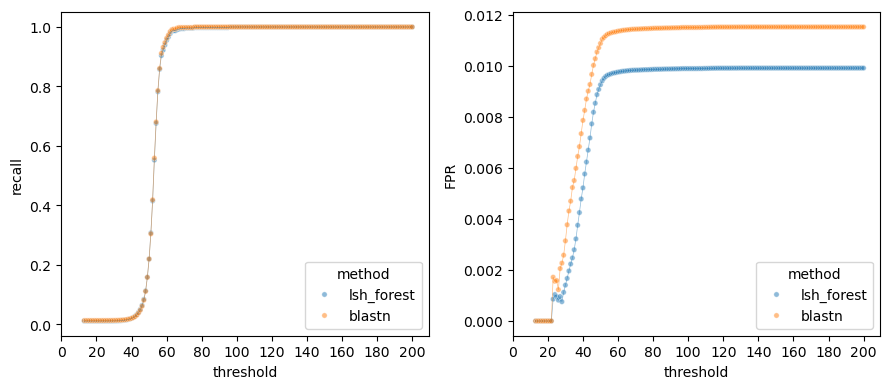

In [28]:
fig,axes = plt.subplots(1,2,figsize=(9,4))
sns.lineplot(combined_recall_df,x="threshold",y="recall",hue="method",ax=axes[0],alpha=0.5,linewidth=0.5,legend=False)
sns.scatterplot(combined_recall_df,x="threshold",y="recall",hue="method",ax=axes[0],alpha=0.5,linewidth=0.5,s=15)
axes[0].set_xticks(np.arange(0,220,20))

sns.lineplot(combined_recall_df,x="threshold",y="FPR",hue="method",ax=axes[1],alpha=0.5,linewidth=0.5,legend=False)
sns.scatterplot(combined_recall_df,x="threshold",y="FPR",hue="method",ax=axes[1],alpha=0.5,linewidth=0.5,s=15)
axes[1].set_xticks(np.arange(0,220,20))
plt.tight_layout()
plt.show()

# 3 - `filter_false_positive_collisions`

In [35]:
%%bash

FASTA_PATH=$PWD/example_data/K562_clean.sample1000.fa.gz
COLLISIONS_PATH=$PWD/example_data/K562_clean.sample1000.collisions.pbz2
THRESHOLD=80
OUTPUT_PATH=$PWD/example_data/K562_clean.sample1000.filtered_collisions.pbz2

./src/hashFrag filter_false_positives -f $FASTA_PATH -c $COLLISIONS_PATH -t $THRESHOLD -o $OUTPUT_PATH

Number of pairwise comparisons to compute: 4948
22 sequences remain after filtering according to a threshold of 80
Filtered collision results written to: /rshare1/ZETTAI_path_WA_slash_home_KARA/home/brett/work/OrthogonalTrainValSplits/hashFrag/example_data/K562_clean.sample1000.filtered_collisions.pbz2


# 4 - `create_orthogonal_splits`

## 4.1 - Converting collision dictionary to sets (i.e., clusters)

That is, each cluster should represent a distinct group of sequences exhibiting homology. There should be no homologous linkages across different clusters.

In [36]:
fasta_dict = helper.load_fasta_as_dictionary(fasta_path)
ids = set(fasta_dict)
N = len(ids)
len(fasta_dict)

1000

In [13]:
filtered_collisions_dict = helper.load_collisions_dictionary(filtered_collisions_path)
len(filtered_collisions_dict)

22

Symmetric here is used to describe both forward and reverse strands (if present) being included in their respective filtered collisions.

In [35]:
symmetric_collisions_dict = defaultdict(set)
for query_id,collisions in tqdm(filtered_collisions_dict.items()):
    query_id_ = helper.get_complementary_id(query_id,ids)
    if query_id_ is not None:
        symmetric_collisions_dict[query_id].add(query_id_)
        symmetric_collisions_dict[query_id_].add(query_id)
    for hit_id in collisions:
        symmetric_collisions_dict[query_id].add(hit_id)
        hit_id_ = helper.get_complementary_id(hit_id,ids)
        if hit_id_ is not None:
            symmetric_collisions_dict[query_id].add(hit_id_)
            if query_id_ is not None:
                symmetric_collisions_dict[query_id_].add(hit_id)
                symmetric_collisions_dict[query_id_].add(hit_id_)

print(len(symmetric_collisions_dict))

100%|█████████████████████████████████████████████| 22/22 [00:00<00:00, 226719.14it/s]

22


### 4.1A - Merge overlapping collision sets (optimal)

In [37]:
collision_setlist = []
for representative_id,group in symmetric_collisions_dict.items():
    collision_set = set()
    collision_set.add(representative_id)
    collision_set.update(group)
    collision_setlist.append(collision_set)
len(collision_setlist)

22

In [38]:
collision_setlist_ = collision_setlist.copy()
while True:
    disjoint_flag = False
    merged_collision_setlist = []
    while collision_setlist_:
        collision_set = collision_setlist_.pop()
        overlaps = []
        for i,merged_collision_set in enumerate(merged_collision_setlist):
            if not collision_set.isdisjoint(merged_collision_set):
                overlaps.append(i)
        if overlaps:
            disjoint_flag = True
            for i in overlaps:
                merged_collision_setlist[i].update(collision_set)
        else:
            merged_collision_setlist.append(collision_set)
    if disjoint_flag: break
    collision_setlist_ = merged_collision_setlist.copy()

In [39]:
merged_collision_setlist

[{'ENSG00000156869_Reversed', 'peak17901', 'peak48253_Reversed', 'peak64755'},
 {'peak61593_Reversed', 'peak8263'},
 {'peak14881_Reversed', 'peak23896_Reversed', 'peak70632'},
 {'peak12783', 'peak62203_Reversed'},
 {'peak19265_Reversed',
  'peak38056',
  'peak41490_Reversed',
  'peak43787',
  'peak5022_Reversed',
  'peak51999',
  'peak61683_Reversed'},
 {'peak50518', 'peak50533'},
 {'peak23699', 'peak48400'}]

### 4.1B - Graph-based clustering of collisions (sub-optimal)

> CURRENTLY, THE BEHAVIOUR SHOULD BE EQUIVALENT TO THE MERGE SECTION 4A!!! (just taking connected components)

TODO: Community detection of graph based on the filtered collisions between sequences (represented as an unweighted adjacency matrix)

In [15]:
import random
import igraph as ig
import scipy.sparse as sp
from collections import defaultdict

In [17]:
collision_idset = set()
for query_id,collisions in symmetric_collisions_dict.items():
    collision_idset.add(query_id)
    collision_idset.update(collisions)
collision_ids = list(collision_idset)

In [18]:
n = len(collision_ids)
id_map = { seq_id:i for i,seq_id in enumerate(collision_ids) }
sparse_mat = sp.dok_matrix((n,n),dtype=np.uint8)
for id_i,collisions in tqdm(symmetric_collisions_dict.items()):
    i = id_map[id_i]
    for id_j in collisions:
        j = id_map[id_j]
        sparse_mat[i,j] = 1
        sparse_mat[j,i] = 1
sparse_mat = sparse_mat.tocsr()
sparse_mat

100%|██████████████████████████████████████████████| 22/22 [00:00<00:00, 30164.98it/s]


<22x22 sparse matrix of type '<class 'numpy.uint8'>'
	with 52 stored elements in Compressed Sparse Row format>

In [19]:
g = ig.Graph.Weighted_Adjacency(
    matrix=sparse_mat,
    mode="undirected",
    loops=False,
    attr="collisions"
)

In [20]:
components = g.connected_components(mode='weak')
similar_groups = []
for component in components:
    similar_groups.append({ collision_ids[i] for i in component })

In [40]:
similar_groups

[{'peak19265_Reversed',
  'peak38056',
  'peak41490_Reversed',
  'peak43787',
  'peak5022_Reversed',
  'peak51999',
  'peak61683_Reversed'},
 {'peak50518', 'peak50533'},
 {'ENSG00000156869_Reversed', 'peak17901', 'peak48253_Reversed', 'peak64755'},
 {'peak14881_Reversed', 'peak23896_Reversed', 'peak70632'},
 {'peak23699', 'peak48400'},
 {'peak12783', 'peak62203_Reversed'},
 {'peak61593_Reversed', 'peak8263'}]

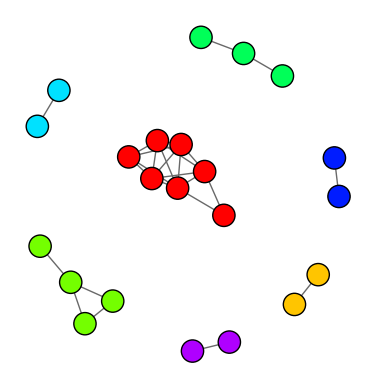

In [21]:
fig, ax = plt.subplots()
ig.plot(
    components,
    target=ax,
    palette=ig.RainbowPalette(),
    vertex_size=0.5,
    vertex_color=list(map(int,ig.rescale(components.membership,(0,200),clamp=True))),
    edge_width=1
)
plt.show()

## 4.2 - Given the similar (homologous) groups identified in Section 4.1, create homology-aware train-test data splits

In [16]:
n_splits = 10
p_train = 0.8
p_test = 0.2

N = len(ids)
train_size = round(p_train*N)
test_size  = round(p_test*N)

train_size,test_size

(800, 200)

In [17]:
for i in tqdm(range(n_splits)):
    split_path = os.path.join(current_dir,"example_data",f"split_{i+1}.csv.gz")
    random.seed(i+1)
    ids_ = list(ids)
    similar_groups_ = similar_groups.copy()

    test_split = set()
    while len(test_split) < test_size and ids_:
        id_x = random.choice(ids_)
        test_split.add(id_x)
        ids_.remove(id_x)

        id_x_ = helper.get_complementary_id(id_x,ids)
        if id_x_ is not None:
            test_split.add(id_x_)
            ids_.remove(id_x_)

        if id_x in collision_idset:
            helper.assert_membership(id_x_,collision_idset)

            for j,group in enumerate(similar_groups_):
                if id_x in group:
                    helper.assert_membership(id_x_,group)
                    group = similar_groups_.pop(j)
                    for id_y in group:
                        if id_x == id_y: continue
                        test_split.add(id_y)
                        ids_.remove(id_y)

                        id_y_ = helper.get_complementary_id(id_y,ids)
                        if id_y_ is not None:
                            helper.assert_membership(id_y_,group)
                            test_split.add(id_y_)
                            ids_.remove(id_y_)

    train_split = set()
    while len(train_split) < train_size and ids_:
        id_x = random.choice(ids_)
        train_split.add(id_x)
        ids_.remove(id_x)

        id_x_ = helper.get_complementary_id(id_x,ids)
        if id_x_ is not None:
            train_split.add(id_x_)
            ids_.remove(id_x_)

        if id_x in collision_idset:
            helper.assert_membership(id_x_,collision_idset)
            for j,group in enumerate(similar_groups_):
                if id_x in group:
                    helper.assert_membership(id_x_,group)
                    group = similar_groups_.pop(j)
                    for id_y in group:
                        if id_x == id_y: continue
                        train_split.add(id_y)
                        ids_.remove(id_y)

                        id_y_ = helper.get_complementary_id(id_y,ids)
                        if id_y_ is not None:
                            helper.assert_membership(id_y_,group)
                            train_split.add(id_y_)
                            ids_.remove(id_y_)

    assert train_split.isdisjoint(test_split)
    helper.write_splits_to_file(train_split,test_split,split_path)


100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 127.06it/s]


In [18]:
len(train_split),len(test_split)

(800, 200)